In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.lines import Line2D 
import numpy as np
import re

## Read Primary Election Data File

In [2]:
xlsx = pd.ExcelFile('scc_election.xlsx')
table_of_contents = pd.read_excel(xlsx, 0, skiprows=3)

scc_primary = {}
for i, name in enumerate(table_of_contents['Contest']):
    if i == 0:
        scc_primary['{}'.format(str(name))] = pd.read_excel(xlsx, i+1)
    else:
        scc_primary['{}'.format(str(name))] = pd.read_excel(xlsx, i+1, header=[0,1])

## Choose Contest and Ballot Option

In [27]:
page_check = raw_input('Please enter your desired contest: ')
key_check = raw_input('Please enter your desired ballot option: ')

page = [substring for substring in scc_primary.keys()
        if re.search(page_check, substring, re.IGNORECASE) is not None]
if len(page) == 1:
    page = page[0]
elif len(page) > 1:
    pages = ['ENTER {} for: {} \n'.format(i, val) for i, val in enumerate(page)]
    page = page[input('Multiple matches found for contest. Please enter the number value corresponding to your desired page:\n{}'.format(''.join(pages)))]
else:
    pages = ['ENTER {} for: {} \n'.format(i, val) for i, val in enumerate(scc_primary.keys())]
    page = page[input('No matches found for contest. Please enter the number value corresponding to your desired page:\n{}'.format(''.join(pages)))]

key = [str(substring) for substring in scc_primary['{}'.format(page)].columns.levels[0]
       if re.search(key_check, substring, re.IGNORECASE) is not None]
if len(key) == 1:
    key = key[0]
elif len(key) > 1:
    keys = ['ENTER {} for: {} \n'.format(i, val) for i, val in enumerate(key)]
    key = key[input('Multiple matches found for ballot option. Please enter the number value corresponding to your desired page:\n{}'.format(''.join(keys)))]
else:
    page_levels = scc_primary['{}'.format(page)].columns.levels[0]
    keys = ['ENTER {} for: {} \n'.format(i, val) for i, val in enumerate(page_levels)]
    key = page_levels[input('No matches found for ballot option. Please enter the number value corresponding to your desired page:\n{}'.format(''.join(keys)))]

print "\n\nYou have selected the contest: {}".format(page)
print "You have selected the ballot option: {}".format(key)

Please enter your desired contest: Measure A
Please enter your desired ballot option: Yes


You have selected the contest: Measure A - City of Santa Clara Charter Amendment (Vote For 1)
You have selected the ballot option: YES


## Wrangle Data

In [28]:
df_amount = 50
min_reg_voters = 300
precinct_type = 'all'
sort_by = 'Voter Turnout'

df = scc_primary['Registered Voters']
df = scc_primary['Registered Voters'].copy()[scc_primary['Registered Voters']['Registered Voters'] > min_reg_voters]
if precinct_type == 'all':
    df = df
elif precinct_type == 'precinct':
    df = df.copy()[df['County'].str.contains("MAIL") == False]
elif precinct_type == 'mail':
    df = df.copy()[df['County'].str.contains("MAIL") == True]

df['Voter Turnout'] = [float(str(i).strip('%')) for i in df['Voter Turnout']]
df = df.dropna(how='any')
df = df.drop(df.tail(1).index)
df = df.sort_values(sort_by, ascending=False)

df_joined = df.join(scc_primary['{}'.format(page)], on='County', how='left')
df_joined['Percent Votes'] = df_joined['{}'.format(key),'Total Votes'] / df_joined.iloc[:,-1]
df_joined = df_joined.dropna()
df_joined = df_joined.head(df_amount)
df_joined = df_joined.sort_values(sort_by, ascending=True)


cmap = 'RdBu'
normalize_color = True

if normalize_color == True:
    percent_votes_normed = (df_joined['Percent Votes'] - min(df_joined['Percent Votes'])) / (max(df_joined['Percent Votes']) - min(df_joined['Percent Votes']))
    color = cm.RdBu(percent_votes_normed)
    vmin, vmax = min(df_joined['Percent Votes']), max(df_joined['Percent Votes'])
else:
    color = cm.RdBu(df_joined['Percent Votes'])
    vmin, vmax = 0, 1

In [29]:
df_joined.head()

,County,Registered Voters,Ballots Cast,Voter Turnout,"(Unnamed: 0_level_0, Registered Voters)","(NO, 99)","(NO, Total Votes)","(YES, Election)","(YES, Total Votes)","(YES, Total)",Percent Votes
814,PCT 4326,1259,188,14.93,1259.0,129.0,95.0,80.0,80.0,175.0,0.457143
798,PCT 4269,766,120,15.67,766.0,105.0,43.0,67.0,67.0,110.0,0.609091
773,PCT 4203,859,137,15.95,859.0,10.0,63.0,63.0,63.0,126.0,0.500000
791,PCT 4256,1345,218,16.21,1345.0,108.0,80.0,124.0,124.0,204.0,0.607843
801,PCT 4272,1050,182,17.33,1050.0,93.0,81.0,95.0,95.0,176.0,0.539773


In [30]:
min_regvot = min(df_joined['Registered Voters'])
max_regvot = max(df_joined['Registered Voters'])
mean_regvot = np.mean(df_joined['Registered Voters'])
min_turnout = min(df_joined['Voter Turnout'])
max_turnout = max(df_joined['Voter Turnout'])

## Plot Data

Major credit to https://datasciencelab.wordpress.com/2013/12/21/beautiful-plots-with-pandas-and-matplotlib/ for visualization

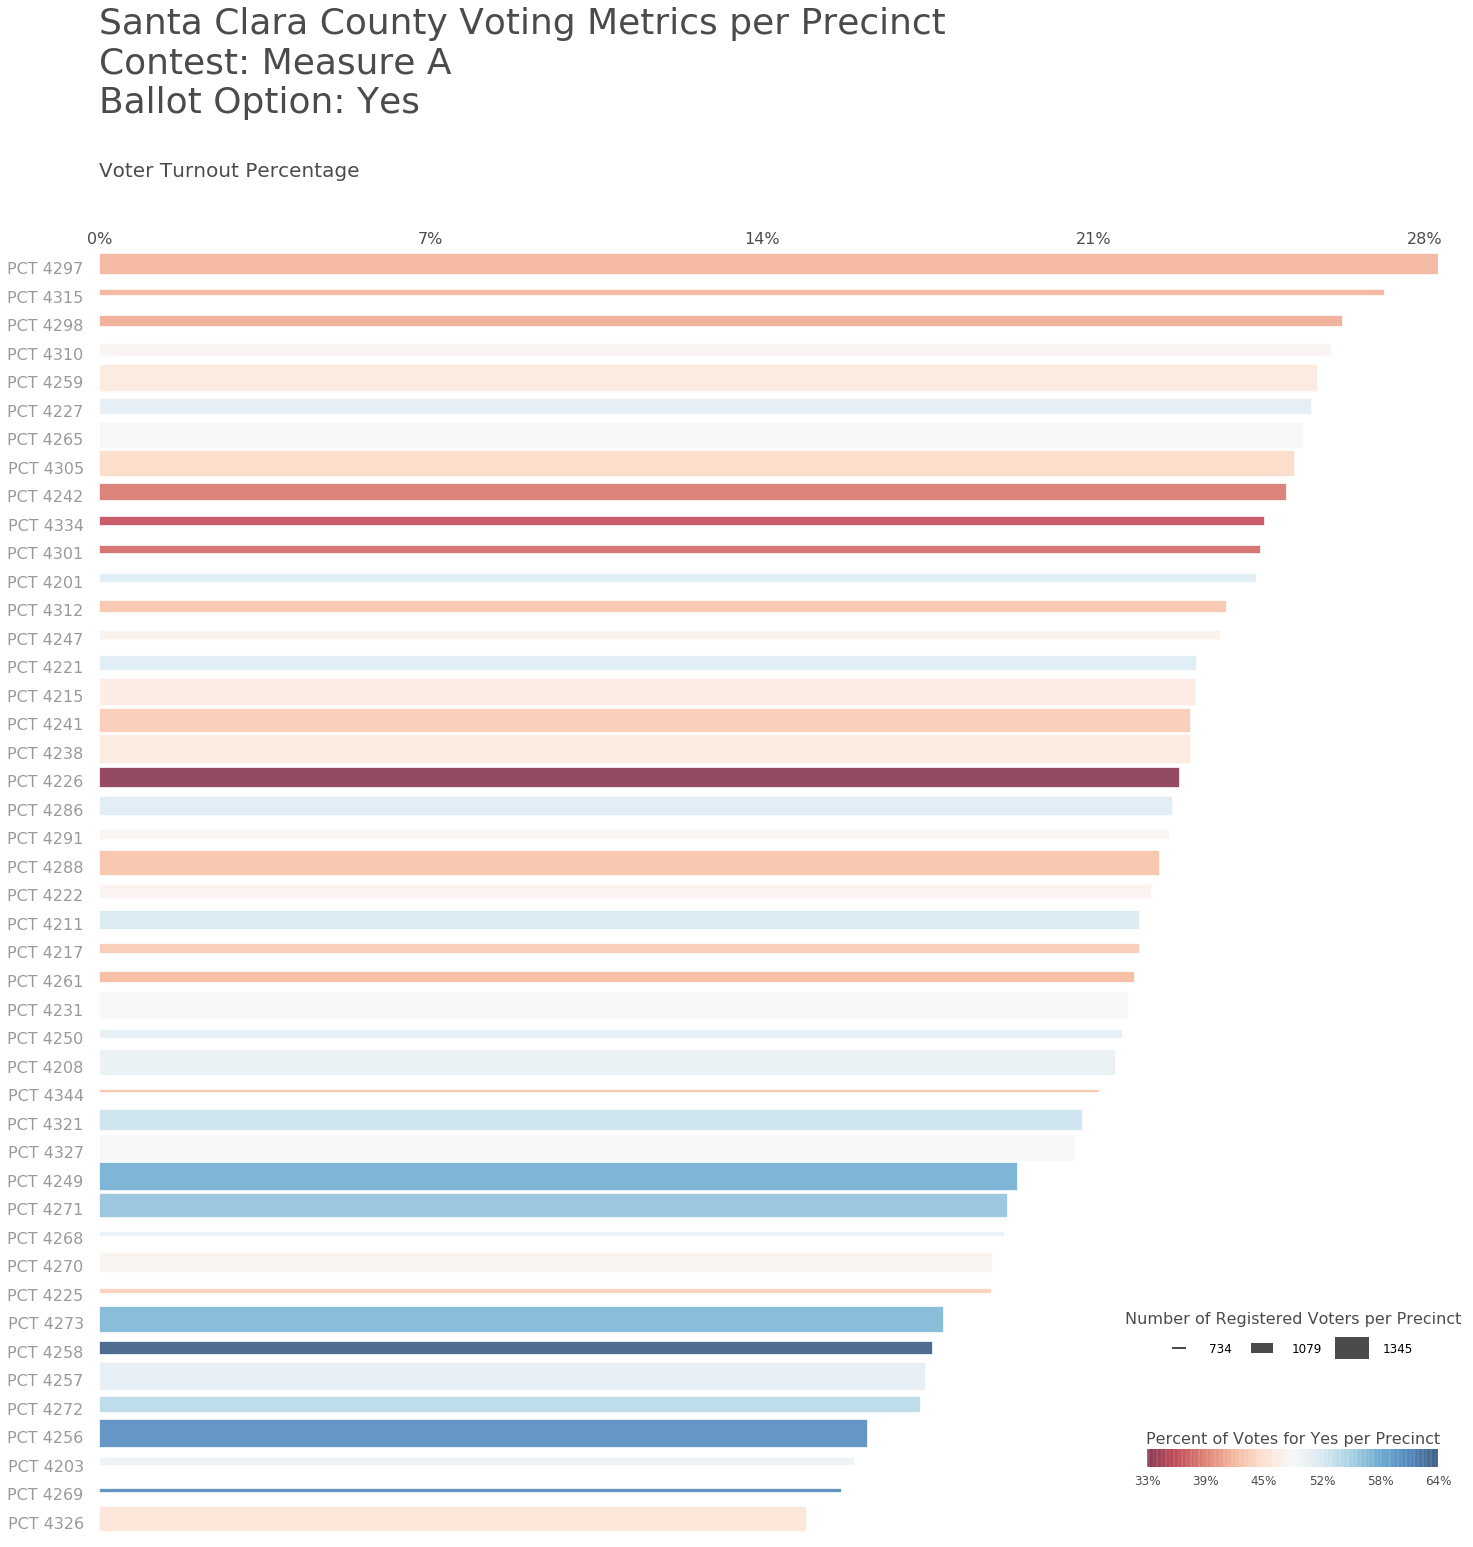

In [31]:
alpha = .7

fig = plt.figure(figsize=(24,12+len(df_joined)/4))
ax = fig.add_subplot(111)

df_joined['Voter Turnout'].plot(kind='barh', ax=ax, alpha=.7,
                             legend=False, color=color,
                             edgecolor='w', xlim=(0, max_turnout),
                             title='Santa Clara County Voting Metrics per Precinct\nContest: {}\nBallot Option: {}'.format(page_check, key_check))
ax.grid(False)
ax.set_frame_on(False)
ax.set_title(ax.get_title(), fontsize=36, alpha=alpha, ha='left', y=1.8)
plt.subplots_adjust(top=0.9)
ax.title.set_position((0, 1.105))

ax.xaxis.set_label_position('top')
ax.set_xlabel('Voter Turnout Percentage', fontsize=20, alpha=alpha, ha='left')
ax.xaxis.set_label_coords(0, 1.06)
ax.xaxis.tick_top()
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

xticks = np.linspace(0, int(max_turnout), int(max_turnout/5.))
ax.xaxis.set_ticks(xticks)
ax.set_xticklabels(['{:.0f}%'.format(val) for val in xticks], fontsize=16, alpha=alpha)

yticks = df_joined['County']
ax.set_yticklabels(yticks, fontsize=16, alpha=.4)
ax.yaxis.set_tick_params(pad=12)  

# Setting subplot location for bar thickness and colorbar
ax2 = fig.add_subplot(248)
ax2.grid(False)
ax2.set_frame_on(False)
ax2.set_yticklabels([])
ax2.set_xticklabels([])
ax2.yaxis.set_ticks_position('none')
ax2.xaxis.set_ticks_position('none')

# Bar Thickness
hmin, hmax = 0.1, 1.0
xmin, xmax = min_regvot, max_regvot
f = lambda x: hmin + (hmax-hmin)*(x-xmin)/(xmax-xmin)
heights = [f(x) for x in df_joined['Registered Voters']]
for container in ax.containers:
    for i, child in enumerate(container.get_children()):
        child.set_y(child.get_y()- 0.125 + 0.5-heights[i]/2)
        plt.setp(child, height=heights[i])

# Bar Thickness Legend
l1 = Line2D([], [], linewidth=2, color='k', alpha=alpha) 
l2 = Line2D([], [], linewidth=10, color='k', alpha=alpha) 
l3 = Line2D([], [], linewidth=22, color='k', alpha=alpha)
labels = [str(min_regvot), str(int(mean_regvot)), str(max_regvot)]
leg = ax2.legend([l1, l2, l3], labels, ncol=3, frameon=False, fontsize=12, 
                 bbox_to_anchor=[.5, -.1], loc='center', handlelength=1, 
                 handletextpad=2, columnspacing=2,
                 title='Number of Registered Voters per Precinct')
plt.setp(leg.get_title(), fontsize=16, alpha=alpha)
leg.get_title().set_position((0, 10))

# Colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=mpl.colors.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = plt.colorbar(sm, ax=ax2, orientation='horizontal', alpha=.25, aspect=16, pad=.25)
cbar.solids.set_edgecolor("face")
cbar.outline.set_visible(False)
cbar.ax.tick_params(labelsize=12)
mytks = np.arange(vmin, vmax+.01, (vmax-vmin)/5.)
cbar.set_ticks(mytks)
cbar.ax.set_xticklabels(['{:.0f}%'.format(a*100) for a in mytks], alpha=alpha)
cbar.ax.set_title('Percent of Votes for {} per Precinct'.format(key_check), alpha=alpha, fontsize=16)
cbarxtks = plt.getp(cbar.ax.axes, 'xticklines')
plt.setp(cbarxtks, visible=False)
plt.savefig('test.png', bbox_inches='tight', dpi=300)
plt.show()